# Modeling fire spreading using Linear Reaction-Convection-Diffusion Equation
### Daniel San Martín

## Linear Reaction-Convection-Diffusion Equation

The linear reaction-convection-diffusion equation is defined by

\begin{equation}
    \frac{\partial u}{\partial t} = \mu \nabla^2u - \nabla \cdot (u\textbf{v})+au,
\end{equation}

where $u$ can represent the temperature or concentration of chemical species in a domain $\Omega \in \mathbb{R}^n$, $\mu>0$ is the diffusion constant, $\textbf{v}(\textbf{x})=(v_1(\textbf{x}), ..., v_n(\textbf{x}))$ is a velocity field of flow fluid and $a(\textbf{x})$ is a reaction rate.

### Diffusion term

The model is based in the process of particles movement and is defined by 

\begin{equation}
    \begin{split}
        \mu \nabla^2u & = \mu\left(\frac{\partial^2 u}{\partial x_1^2} 
            + ... + \frac{\partial^2 u}{\partial x_n^2}\right). \\
    \end{split}
\end{equation}

For $\textbf{x}\in\mathbb{R}^2$ we have
\begin{equation}
    \mu \nabla^2u = \mu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right).
\end{equation}

### Convection term

The model includes the effect of a vector field $\textbf{v}(\textbf{x})=(v_1(\textbf{x}), ..., v_n(\textbf{x}))$ in the form 

\begin{equation}
    \begin{split}
        \nabla \cdot (u\textbf{v}) & = \sum_{i=1}^n\frac{\partial(uv_i)}{\partial x_i}.
    \end{split}
\end{equation}

For $\textbf{x}\in\mathbb{R}^2$ we have
\begin{equation}
    \begin{split}
        \nabla \cdot (u\textbf{v}) & = \frac{\partial(uv_1)}{\partial x} + \frac{\partial(uv_2)}{\partial y} \\
         & = \frac{\partial u}{\partial x}v_1 + u\frac{\partial v_1}{\partial x} +
             \frac{\partial u}{\partial y}v_2 + u\frac{\partial v_2}{\partial y}
    \end{split}
\end{equation}

### Reaction term

The reaction term is a linear approximation of chemical kinetics and is defined by $au$, where $a$ may be a real number or a escalar field.

<!--\begin{equation}
    au = a(\textbf{x})u(\textbf{x}).
\end{equation}

For $\textbf{x}\in\mathbb{R}^2$ we have $a(x,y)u(x,y)$-->

## Fire spreading

Assuming that we have a heterogeneous fuel and a constant wind, we want to model a fire propagation (heat transport) using the PDE as follow

\begin{equation}
    \begin{split}
        \frac{\partial u}{\partial t} & = \mu \nabla^2u - \nabla \cdot (u\textbf{v})+au ~ \text{in} ~ \Omega \\
            u\big|_{\Gamma} & = f \\
            u(x,y,0) & = u_0(x,y).
    \end{split}
\end{equation}

where $\Gamma=\partial\Omega$, the domain's boundary.

### Numerical Methods

To compute the derivatives we use Chebyshev differentiation matrix for spatial domain and for time domain we use Euler's Method.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
def cheb(N):
    if N == 0:
        D = 0
        x = 1
        return D, x
    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.hstack((2, np.ones(N - 1), 2)) * ((-1.)**np.arange(N + 1))
    X = np.tile(x, (N + 1, 1)).T
    dX = X - X.T
    D = np.outer(c, 1./c) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D.T, axis=0))
    return D,x

In [27]:
def plotIC(x, y, u):
    plt.title("Initial Condition")
    count = plt.contourf(x, y, u, cmap=cm.jet)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [28]:
def plotReaction(x, y, a):
    plt.title("Reaction Rate")
    count = plt.contourf(x, y, a, cmap=cm.jet)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [29]:
def plotFluid(x, y, v1, v2):
    plt.title("Fluid")
    quiv = plt.quiver(Xv, Yv, V1N, V2N)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [30]:
N = 20

# x variable in [-1,1], Chebyshev
Nx = N; Dx, x = cheb(Nx)
D2x = np.dot(Dx, Dx);

# y variable in [-1,1], Chebyshev
Ny = N; Dy, y = cheb(Ny) 
D2y = np.dot(Dy, Dy)

# Grids
X, Y = np.meshgrid(x,y)
Xv, Yv = np.mgrid[-1:1:21j, -1:1:21j]

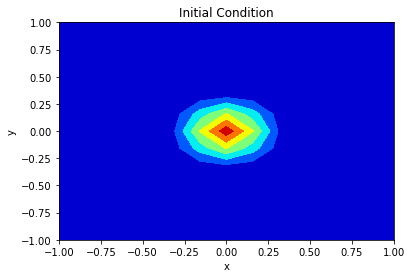

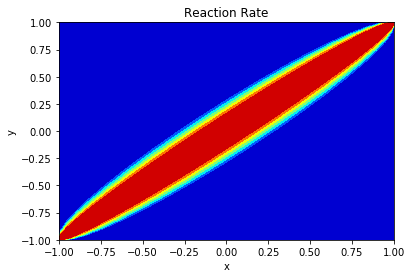

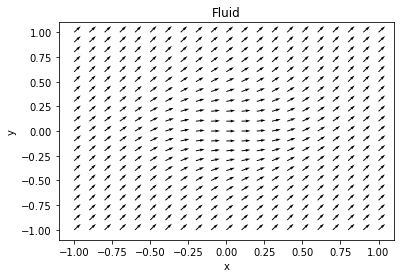

In [33]:
# Initial condition
v = np.exp(-20*(X**2 + Y**2))
plotIC(X, Y, v)

# Parameters
mu = 1
dt = 1e-4
tmax = 4000

# Reaction rate
#a = X + Y#X**2 + Y**2 # np.cos(np.pi/8*X*Y)
a = np.zeros(X.shape) + np.diag(np.ones(X.shape[0]-1) * 5, -1) \
    + np.diag(np.ones(X.shape[0]) * 5, 0) + np.diag(np.ones(X.shape[0]-1) * 5, 1)
plotReaction(X, Y, a)

# Vector Field
V1 = np.ones(X.shape) #Xv + Yv # -8*X*np.exp(-4*(X**2 + Y**2))
V2 = np.sin(X**2 + Y**2) #Xv + Yv # -8*Y*np.exp(-4*(X**2 + Y**2))
speed = np.sqrt(V1**2 + V2**2)
speed[speed == 0] = 1e-16
V1N = V1/speed
V2N = V2/speed
plotFluid(Xv, Yv, V1N, V2N)

In [34]:
u = [v]
t = [0]

# Euler
for n in range(tmax):
    
    diff = mu*(np.dot(v, D2x) + np.dot(D2y, v))    
    conv = np.dot(np.dot(v, Dx), V1N) + np.dot(v, np.dot(V1N, Dx)) \
        + np.dot(np.dot(Dy, v), V2N) + np.dot(v, np.dot(Dy, V2N))
    reac = np.dot(a, v) #np.zeros(diff.shape)
    
    v = v + dt*(diff - conv + reac)

    # Border condition
    v[0,:] = np.zeros(N+1)
    v[-1,:] = np.zeros(N+1)
    v[:,0] = np.zeros(N+1)
    v[:,-1] = np.zeros(N+1)
    
    if (n % 2 == 0): # keep some plots
        u.append(v)
        t.append(n*dt)

In [35]:
fine = np.linspace(-1, 1, 2*N)
Xf, Yf = np.meshgrid(fine, fine)

def plot(d, i, elev, azim):
    f = interp2d(x, y, u[i], kind='cubic')
    v = f(fine, fine)    
    vmn, vmx = np.min(u[0]), np.max(u[0])
    fig = plt.figure(figsize=(10, 8))
    if d == 2:        
        ax = fig.gca(projection='3d')                        
        surf = ax.plot_surface(Xf, Yf, v, rstride=1, cstride=1, cmap=cm.jet, vmin=vmn, vmax=vmx)  
        fig.colorbar(surf)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("u(x,y)")
        ax.set_zlim([vmn, vmx])
    else:        
        cont = plt.contourf(Xf, Yf, v, cmap=cm.jet, vmin=vmn, vmax=vmx)
        fig.colorbar(cont)
        
    plt.title("$t$: " + "{:10.2f}".format(t[i]))
    plt.show()

slider = widgets.IntSlider(
    value=0, 
    min=0, 
    max=len(t)-1, 
    step=1, 
    description='Time step:',
    continuous_update=False,
    readout=True,
    readout_format='d'
)

ele = widgets.IntSlider(
    value=30,
    min=0,
    max=90,
    step=10,
    description='Elevation:'
)

azi = widgets.IntSlider(
    value=220,
    min=220,
    max=270,
    step=10,
    description='Azimuth:'
)

drop = widgets.Dropdown(
    options={'Contour': 1, 'Surface': 2},
    value=1,
    description='Plot:',
)

widgets.interact(plot, d=drop, i=slider, elev=ele, azim=azi)

interactive(children=(Dropdown(description='Plot:', options={'Contour': 1, 'Surface': 2}, value=1), IntSlider(value=0, continuous_update=False, description='Time step:', max=2000), IntSlider(value=30, description='Elevation:', max=90, step=10), IntSlider(value=220, description='Azimuth:', max=270, min=220, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>